# Figure generation

In [1]:
!git clone https://github.com/mtcarilli/GCCP_2022.git

Cloning into 'GCCP_2022'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 145 (delta 10), reused 49 (delta 7), pack-reused 93
Receiving objects: 100% (145/145), 669.13 MiB | 28.06 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Checking out files: 100% (116/116), done.


In [2]:
!mv GCCP_2022/* .

In [4]:
!pip install numdifftools

In [39]:
!git clone https://github.com/BlakeRMills/MetBrewer.git

Cloning into 'MetBrewer'...
remote: Enumerating objects: 560, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 560 (delta 93), reused 51 (delta 51), pack-reused 452
Receiving objects: 100% (560/560), 154.95 MiB | 29.92 MiB/s, done.
Resolving deltas: 100% (265/265), done.


In [40]:
!pip install ./MetBrewer/Python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./MetBrewer/Python
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 11.2 MB 12.0 MB/s 
     |████████████████████████████████| 930 kB 41.8 MB/s 
  Created wheel for met-brewer: filename=met_brewer-1.0-py3-none-any.whl size=5400 sha256=ef5407db93ab7d56afe7ea544af05a91b5b9b0a67b6abfb97e229d7d33acedfb
  Stored in directory: /tmp/pip-ephem-wheel-cache-olxrvuu_/wheels/c8/a2/5d/95e01f22a551728db955879bcbebd4820d1ae0e5a218fdb658
Successfully built met-brewer
  Attempting uninstall: matplotlib
    Found ex

In [3]:
import met_brewer

In [4]:
import numpy as np
import pandas as pd
from torchsummary import summary
import scipy
import time

import ypred_module as ypm
import exact_cme as cme
import train_conditional as train
import tools_conditional as tools
import direct_module as direct

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 
import seaborn as sns

In [13]:
from met_brewer import met_brew
from matplotlib.colors import LinearSegmentedColormap


In [36]:
# a e s t h e t i c s
fs = 14
n = 123


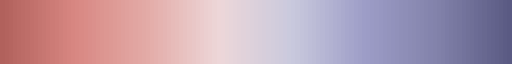

In [37]:
cmap

In [23]:
!mkdir figs

-----

# Figure 1: Approximation Overview


### Figure 2: Conditional distributions

Plotting for 5 kernel functions for ease of visualization. 

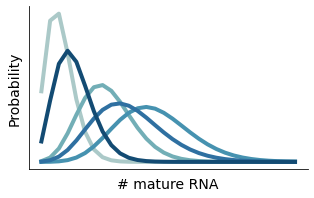

In [109]:
k = np.arange(0,30)

# can play around with the values for different shapes
ns = [20,30,30,15,15,20]
ps = [0.9,0.8,0.7,0.6,0.8,0.9]

fig1,ax1 = plt.subplots(1,1,figsize=(5,3))
# please change colors for asthetics
# colors = ['lawngreen','green','limegreen','lightgreen','darkgreen',]
colors = ("#abc9c8", "#72aeb6", "#4692b0", "#2f70a1", "#134b73", "#0a3351")
for i in range(5):
    P = scipy.stats.nbinom.pmf(k, ns[i], ps[i], loc=0)
    plt.plot(P,'-',c=colors[i],linewidth=4)

plt.xticks([])
plt.yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.xlabel('# mature RNA',fontsize=fs)
plt.ylabel('Probability',fontsize=fs)

plt.savefig('./figs/kernels.png',dpi=450)

### Figure 2: Conditional

Use the Approximation for 2b.

In [46]:
# met_brew(name="Greek", n=n, brew_type="continuous").reverse()

/content/ypred_module.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = torch.tensor(m_range+1,dtype=torch.long)


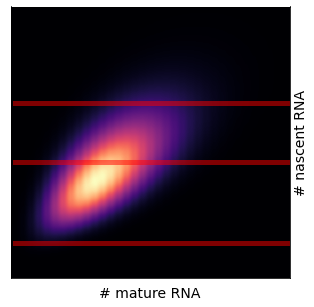

In [281]:
p_vec = np.log10(np.array([10,.1,.8]))

# cmap=LinearSegmentedColormap.from_list('cm', met_brew(name="Peru2", n=n, brew_type="continuous"), N=n)
# cmap='Wistia'
# cmap='summer'
# cmap=LinearSegmentedColormap.from_list('cm', met_brew(name="VanGogh3", n=n, brew_type="continuous")[::-1], N=n)
cmap='magma'
# cmap='spring'
# [::-1]

p, true = cme.calculate_exact_cme(p_vec,method='quad_vec',xmax_fun=tools.xmax_fun) 
pred = tools.predict_full_pmf(p_vec,true,model=ypm.model)

fig1,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(5,5))

vmax = np.max(np.concatenate((pred.flatten(),true.flatten())))
vmin = np.min(np.concatenate((pred.flatten(),true.flatten())))

# ax1[0].imshow(true,aspect='auto',vmin=vmin,vmax=vmax)

hell_ = tools.hellinger(pred.flatten(),true.flatten())

ax1.imshow(pred,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)
ax1.invert_yaxis()
ax1.yaxis.set_label_position("right")

ax1.set_xlabel('# mature RNA',fontsize=fs)
ax1.set_ylabel('# nascent RNA',fontsize=fs)

desired_conditionals = [30,100,150]
for i in range(len(desired_conditionals)):
    plt.plot([0,pred.shape[1]-0.8],[desired_conditionals[i]]*2,alpha=0.5,linewidth=5,color='r')

ax1.set_xticks([])
ax1.set_yticks([])
plt.savefig('./figs/approx_pmf.png',dpi=450)

### Conditionals for plots in 2c

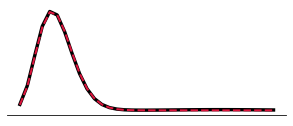

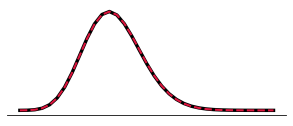

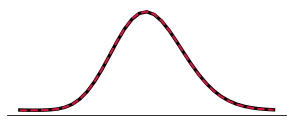

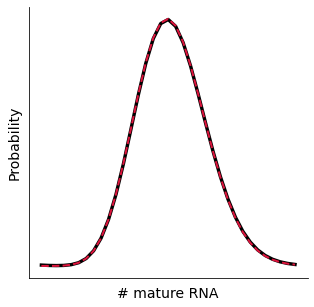

In [284]:
i=0
# lw=
for cond in desired_conditionals:
    fig1,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(5,2))
    plt.plot(true[cond,:],'k-',label='True PMF',linewidth=3.4)
    plt.plot(pred[cond,:],color='crimson',label='Approximated PMF',linewidth=2,linestyle='--')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # plt.xlabel('# mature RNA')
    # plt.ylabel('Probability')
    plt.savefig('./figs/cond{:.0f}.png'.format(i),dpi=450)
    i+=1
    # # plt.title(f'P (m | n = {cond})',fontsize=20)
    # plt.legend()
fig1,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
plt.plot(true[cond,:],'k-',label='True PMF',linewidth=3.4)
plt.plot(pred[cond,:],color='crimson',label='Approximated PMF',linewidth=2,linestyle='--')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)

plt.xlabel('# mature RNA',fontsize=fs)
plt.ylabel('Probability',fontsize=fs)
plt.savefig('./figs/condbig{:.0f}.png'.format(i),dpi=450)


In [126]:
!zip  figs.zip ./figs/* 

  adding: figs/approx_pmf.png (deflated 38%)
  adding: figs/cond0.png (deflated 18%)
  adding: figs/cond1.png (deflated 15%)
  adding: figs/cond2.png (deflated 15%)
  adding: figs/condbig3.png (deflated 20%)
  adding: figs/kernels.png (deflated 9%)


-----
# Figure 2 : Performance



### Figure 2a: Time vs. Hellinger Distance 
Plotting timing vs. hellinger distance (normalized by state size of PMF) for various methods of calculating and approximating full Probability Mass Functions.

In [285]:
compare_array_norm_hellinger = np.load('./results/compare_array_norm_hellinger.npy')
direct_hellinger = np.load('./results/direct_model256_3_4t_hellinger_norm.npy')
direct_times = np.load('./results/direct_model256_3_4t_times_norm.npy')

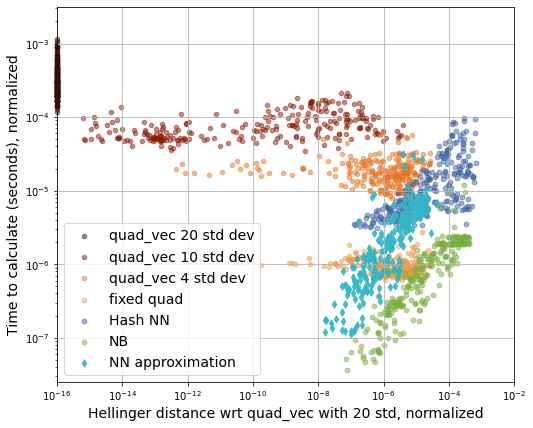

In [286]:
start = 0
stop = 256


fig, ax = plt.subplots(figsize=(8.2, 6.9))
cmap_quad = ("#3c0d03", "#8d1c06", "#e67424", "#ed9b49", "#f5c34d") #greek
cmap_ml = ("#d7aca1", "#ddc000", "#79ad41", "#34b6c6", "#4063a3") #isfahan2
#ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

alpha=0.5

plt.scatter(compare_array_norm_hellinger[0,start:stop,1]+1e-16,compare_array_norm_hellinger[0,start:stop,0],
            label='quad_vec 20 std dev',s=20,c=cmap_quad[0],clip_on=False,alpha=alpha)
plt.scatter(compare_array_norm_hellinger[1,start:stop,1],compare_array_norm_hellinger[1,start:stop,0],
            label='quad_vec 10 std dev',s=20,c=cmap_quad[1],alpha=alpha)
plt.scatter(compare_array_norm_hellinger[2,start:stop,1],compare_array_norm_hellinger[2,start:stop,0],
            label='quad_vec 4 std dev',s=20,c=cmap_quad[2],alpha=alpha)
plt.scatter(compare_array_norm_hellinger[3,start:stop,1],compare_array_norm_hellinger[3,start:stop,0],
            label='fixed quad',s=20,c=cmap_quad[3],alpha=alpha)
plt.scatter(direct_hellinger[start:stop],direct_times[start:stop],
            label='Hash NN',s=23,c=cmap_ml[4],alpha=alpha)
plt.scatter(compare_array_norm_hellinger[5,start:stop,1],compare_array_norm_hellinger[5,start:stop,0],
            label='NB',s=23,c=cmap_ml[2],alpha=alpha)
plt.scatter(compare_array_norm_hellinger[4,start:stop,1],compare_array_norm_hellinger[4,start:stop,0],
            label='NN approximation',s=27,c=cmap_ml[3],marker='d',alpha=0.9)


plt.xlabel('Hellinger distance wrt quad_vec with 20 std, normalized',fontsize=fs)
plt.ylabel('Time to calculate (seconds), normalized',fontsize=fs)
# plt.title("Timing vs. Hellinger Distance over Grid", fontdict={'fontsize': 20})
plt.grid()
plt.legend(fontsize=fs)
plt.yscale('log')
plt.xscale('log')
xl = np.asarray([-16,-2],dtype=float)
yl = np.asarray([-7.6,-2.5],dtype=float)
plt.xlim(10**xl)
plt.ylim(10**yl)
plt.savefig('./figs/time_hellinger_scatter.png',dpi=450)

In [287]:
from scipy import stats

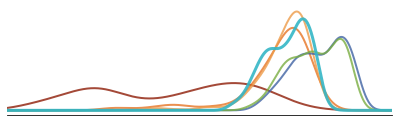

In [288]:
fig, ax = plt.subplots(figsize=(6.9, 2))

x_ = np.linspace(xl[0],xl[1],2000)
alpha = 0.8
for i in range(1,4):
    kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[i,start:stop,1]))
    plt.plot(x_,kde(x_),color=cmap_quad[i],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(direct_hellinger[start:stop]))
plt.plot(x_,kde(x_),color=cmap_ml[4],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[5,start:stop,1]))
plt.plot(x_,kde(x_),color=cmap_ml[2],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[4,start:stop,1]))
plt.plot(x_,kde(x_),color=cmap_ml[3],linewidth=3,alpha=0.9)
plt.xlim((xl))

plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('./figs/hellinger_kde.png',dpi=450)

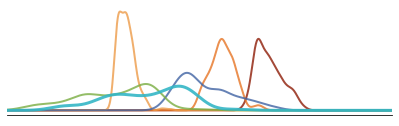

In [289]:
fig, ax = plt.subplots(figsize=(6.9, 2))

x_ = np.linspace(yl[0],yl[1],2000)
alpha = 0.8
for i in range(1,4):
    kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[i,start:stop,0]))
    plt.plot(x_,kde(x_),color=cmap_quad[i],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(direct_times[start:stop]))
plt.plot(x_,kde(x_),color=cmap_ml[4],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[5,start:stop,0]))
plt.plot(x_,kde(x_),color=cmap_ml[2],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[4,start:stop,0]))
plt.plot(x_,kde(x_),color=cmap_ml[3],linewidth=3,alpha=0.9)
plt.xlim(yl)

plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('./figs/time_kde.png',dpi=450)

### Figure 2b: Hellinger Distances over PMF Grids

In [290]:
NN_hellinger = np.load('./results/NN_hellinger.npy')
NB_hellinger = np.load('./results/NB_hellinger.npy')
rand_hellinger = np.load('./results/rand_hellinger.npy')
direct_hellinger_unnorm = np.load('./results/direct_model256_3_4t_hellinger_unnorm.npy')

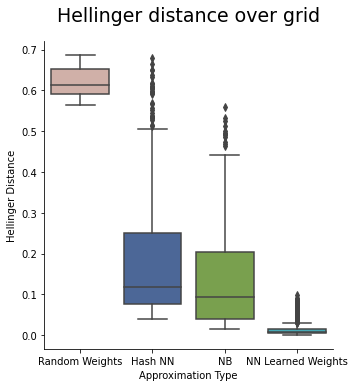

In [291]:
hellinger_data = {'Approximation Type': ['Random Weights']*256*3+['Hash NN']*256*3+ ['NB']*256*3+ ['NN Learned Weights']*256*3,
        'Hellinger Distance': np.concatenate((rand_hellinger,direct_hellinger_unnorm,NB_hellinger,NN_hellinger)) }
hellinger_df = pd.DataFrame.from_dict(hellinger_data) 


# CHANGE to change colors
my_pal = {"NN Learned Weights": cmap_ml[3], "NB": cmap_ml[2], "Hash NN":cmap_ml[4],'Random Weights':cmap_ml[0]}


sns.catplot(x="Approximation Type", y='Hellinger Distance', kind="box",  data=hellinger_df,palette=my_pal)

plt.title('Hellinger distance over grid',fontsize=19);


plt.savefig('./figs/helldist_box.png',dpi=450)

### Figure 2c: Timing for single point

In [292]:
NN_times_onepoint = np.load('./results/NN_times_onepoint.npy')
NB_times_onepoint = np.load('./results/NB_times_onepoint.npy')
direct_times_onepoint = np.load('./results/direct_model256_3_4t_times_onepoint.npy')

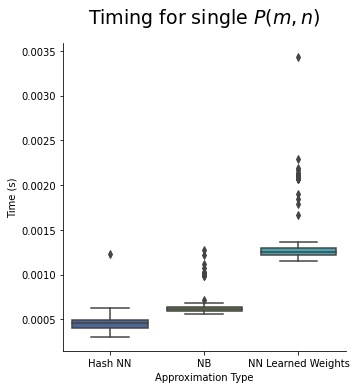

In [293]:
data_time = {'Approximation Type': ['Hash NN']*256*3+['NB']*256*3+ ['NN Learned Weights']*256*3,
        'Time (s)': np.concatenate((direct_times_onepoint,NB_times_onepoint,NN_times_onepoint)) }

time_df = pd.DataFrame.from_dict(data_time) 

sns.catplot(x="Approximation Type", y='Time (s)', 
            kind="box",  data=time_df, palette = my_pal)
plt.title(r'Timing for single $P(m,n)$',fontsize=19);
plt.savefig('./figs/time_box.png',dpi=450)

### Figure 2d: Comparing PMFs

In [295]:
data_array = train.load_data(3,'./data/','256_test_full')


/content/ypred_module.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = torch.tensor(m_range+1,dtype=torch.long)
/content/ypred_module.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MU, VAR, STD, xmax = [torch.tensor(x) for x in train.get_moments(p)]


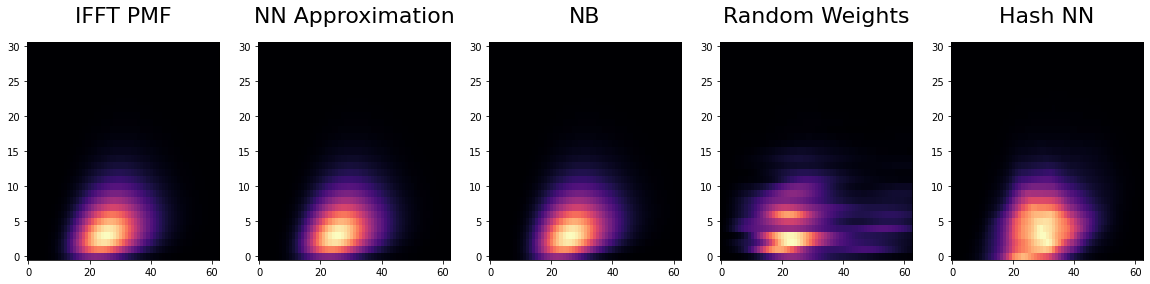

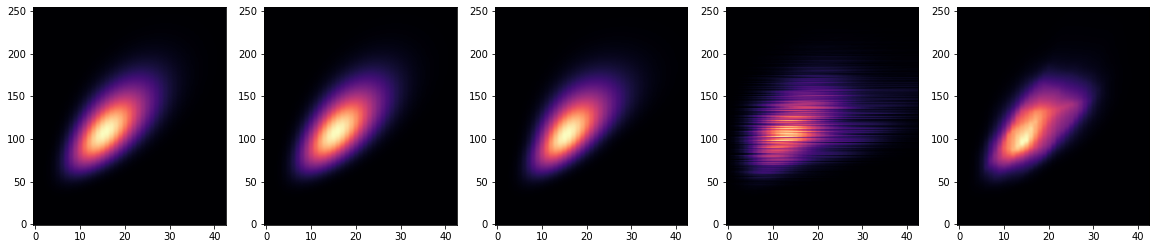

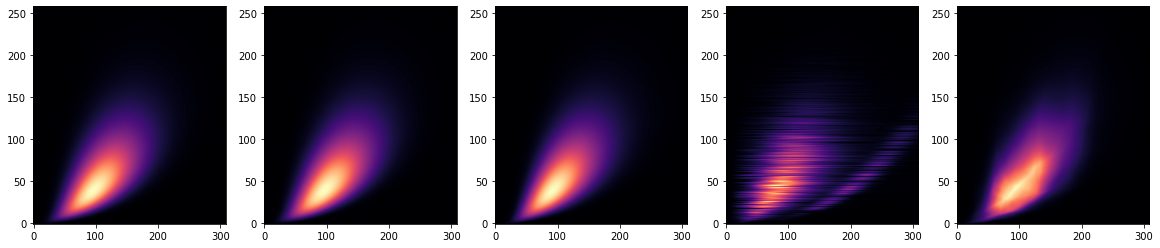

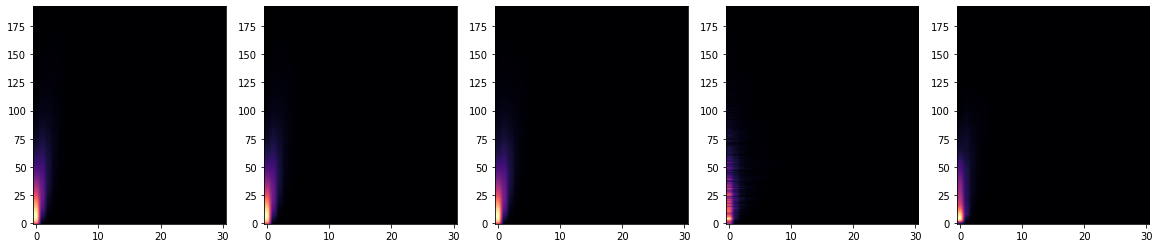

In [297]:
indices = [8,11,22,20]
cmap='magma'

for index,i in enumerate(indices):
    

    pdf = data_array[i][1]
    p_in = data_array[i][0]

    nas_range = np.arange(pdf.shape[0])
    mat_range = np.arange(pdf.shape[1])

    predicted = ypm.get_prob(p_in,nas_range,mat_range,rand_weights=False)
    predicted_rand = ypm.get_prob(p_in,nas_range,mat_range,rand_weights=True)
    predicted_direct = direct.predict_pmf(p_in,nas_range[-1]+1,mat_range[-1]+1)
    N,M = np.meshgrid(range(pdf.shape[0]),range(pdf.shape[1]),indexing='ij')
    NB = ypm.approximate_conditional_tensorval(p_in,N,M).detach().numpy()


    fig1,ax1=plt.subplots(nrows=1,ncols=5,figsize=(20,4))

    ax1[0].imshow(pdf,aspect='auto',cmap=cmap)
    ax1[0].invert_yaxis()


    hell = tools.hellinger(pdf,predicted)
    ax1[1].imshow(predicted,aspect='auto',cmap=cmap)
    ax1[1].invert_yaxis()
    #ax1[1].set_title(f'Hellinger Distance {hell:.5f}',fontdict = {'fontsize' : 15})
    # ax1[1].set_xlabel('# mature')
    # ax1[1].set_ylabel('# nascent')


    hell_NB = tools.hellinger(pdf,NB)
    ax1[2].imshow(NB,aspect='auto',cmap=cmap)
    ax1[2].invert_yaxis()
    #ax1[2].set_title(f'Hellinger Distance {hell_NB:.5f}',fontdict = {'fontsize' : 15})
    #ax1[2].set_xlabel('# mature')
    #ax1[2].set_ylabel('# nascent')



    hell_rand = tools.hellinger(pdf,predicted_rand)
    ax1[3].imshow(predicted_rand,aspect='auto',cmap=cmap)
    ax1[3].invert_yaxis()
    #ax1[3].set_title(f'Hellinger Distance {hell_rand:.5f}',fontdict = {'fontsize' : 15})
    #ax1[3].set_xlabel('# mature')
    #ax1[3].set_ylabel('# nascent')


    hell_direct = tools.hellinger(pdf,predicted_direct)
    ax1[4].imshow(predicted_direct,aspect='auto',cmap=cmap)
    ax1[4].invert_yaxis()
    #ax1[4].set_title(f'Hellinger Distance {hell_direct:.5f}',fontdict = {'fontsize' : 15});
    #ax1[4].set_xlabel('# mature')
    #ax1[4].set_ylabel('# nascent')
    
    if index == 0:
        ax1[0].set_title('IFFT PMF',fontsize=22)
        ax1[1].set_title('NN Approximation',fontsize=22)
        ax1[2].set_title('NB',fontsize=22)
        ax1[3].set_title('Random Weights',fontsize=22)
        ax1[4].set_title('Hash NN',fontsize=22)

    fig.tight_layout()
    plt.savefig('./figs/pmf{:.0f}.png'.format(index),dpi=450)
    # plt.show()

-----

# Figure 3


### Figure 3a: Training/validation loss for final model

In [298]:
best_model_loss = np.load('./models/best_model_meta.npy',allow_pickle=True)

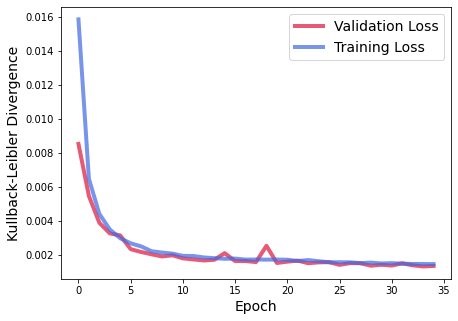

In [299]:
fig = plt.figure(figsize=(7,5))

best_model_loss = np.load('./models/best_model_meta.npy',allow_pickle=True)
train_klds = best_model_loss[2]
valid_klds = best_model_loss[3]

lw=4
alpha=0.7

plt.plot(valid_klds,label='Validation Loss',c='crimson',linewidth=lw,alpha=alpha)
plt.plot(train_klds,label='Training Loss',c='royalblue',linewidth=lw,alpha=alpha)
plt.legend(fontsize=fs)
# plt.title('Training and Validation Loss, Final Model',fontsize=fs)
plt.ylabel('Kullback-Leibler Divergence',fontsize=fs)
plt.xlabel('Epoch',fontsize=fs);
plt.savefig('./figs/kld_epoch.png',dpi=450)

### Figure 3b: Timing for training 

Training time for a varying number of *conditional examples* with 5, 10, or 20 kernel functions. 

In [300]:
times_5npdf = np.load('./results/timing_5npdf.npy')
times_10npdf = np.load('./results/timing_10npdf.npy')
times_20npdf = np.load('./results/timing_20npdf.npy')

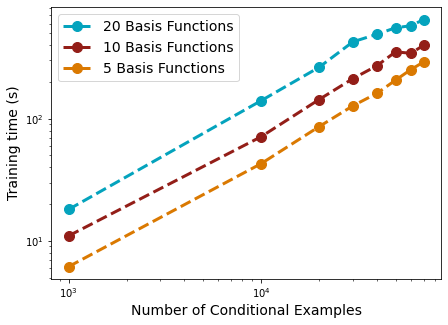

In [301]:
fig = plt.figure(figsize=(7,5))
num_conditionals = times_5npdf[0,:]
# col = ("#a40000", "#16317d", "#007e2f", "#ffcd12", "#b86092", "#721b3e", "#00b7a7")
col=("#04a3bd", "#f0be3d", "#931e18", "#da7901", "#247d3f", "#20235b")
lw=3
markersize=10
plt.plot(num_conditionals,times_20npdf[1,:],label='20 Basis Functions',c=col[0],marker='o',linestyle='--',linewidth=lw,markersize=markersize)
plt.plot(num_conditionals,times_10npdf[1,:],label='10 Basis Functions',c=col[2],marker='o',linestyle='--',linewidth=lw,markersize=markersize)
plt.plot(num_conditionals,times_5npdf[1,:],label='5 Basis Functions',c=col[3],marker='o',linestyle='--',linewidth=lw,markersize=markersize)
# plt.title('Training Time vs. Number of Conditional Examples (1 Epoch)')
plt.xlabel('Number of Conditional Examples',fontsize=fs)
plt.ylabel('Training time (s)',fontsize=fs)
plt.legend(fontsize=fs)
plt.xscale('log')
plt.yscale('log')
plt.savefig('./figs/time_numex.png',dpi=450)

### Figure 3c-e: Varying Nodes, Kernel Functions, Examples
Plot the 5th, 95th percentile and mean Kullback-Leibler divergence for the testing parameters (stored in ./data/256_test_i.npy) as a function of changing the number of hidden nodes in the two hidden layers, the number of kernel functions, and the number of training parameters. 

In [302]:
klds_hid = np.load('./results/testing_klds_hid.npy',allow_pickle=True)
klds_npdf = np.load('./results/testing_klds_npdf.npy',allow_pickle=True)
klds_param = np.load('./results/testing_klds_param.npy',allow_pickle=True)

In [303]:
# get mean and quantiles for best model 
main_mean = np.mean(klds_param[-1,1])
main_95th = np.percentile(klds_param[-1,1],95)
main_5th = np.percentile(klds_param[-1,1],5)

### Figure 3c: Varying Nodes in Hidden Layers

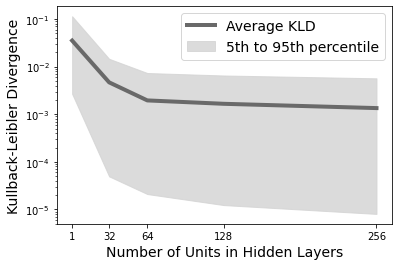

In [304]:
hid_95th = [ np.percentile(hid[1],95) for hid in klds_hid ] 
hid_5th = [ np.percentile(hid[1],5) for hid in klds_hid ] 
hid_means =  [ np.mean(hid[1]) for hid in klds_hid ] 


# add for best model
hid_units = [hid[0] for hid in klds_hid]
hid_units.append(256)
hid_means.append(main_mean)
hid_95th.append(main_95th)
hid_5th.append(main_5th)


lw=4
fig, ax = plt.subplots()
ax.plot(hid_units[:], hid_means[:], '-',label='Average KLD',color='dimgray',linewidth=lw)
ax.fill_between(hid_units[:], hid_95th[:], hid_5th[:], alpha=0.8, label = '5th to 95th percentile',color='lightgray')
# plt.title('KLD vs. Number of Units in Hidden Layers')
plt.ylabel('Kullback-Leibler Divergence',fontsize=fs)
plt.xlabel('Number of Units in Hidden Layers',fontsize=fs)
plt.xticks(hid_units[:], hid_units[:])
plt.yscale('log')
plt.legend(fontsize=fs)

plt.savefig('./figs/kld_nunits.png',dpi=450)

### Figure 3d: Varying Number of Kernel Functions

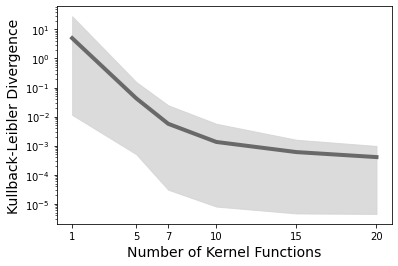

In [305]:
npdf = [ p[0] for p in klds_npdf]
npdf.insert(3,10)

npdf_95th = [ np.percentile(p[1],95) for p in klds_npdf ] 
npdf_95th.insert(3,main_95th)
npdf_5th = [ np.percentile(p[1],5) for p in klds_npdf] 
npdf_5th.insert(3,main_5th)
npdf_means =  [ np.mean(p[1]) for p in klds_npdf ] 
npdf_means.insert(3,main_mean)

npdf = [ p[0] for p in klds_npdf]
npdf.insert(3,10)


fig, ax = plt.subplots()
ax.plot(npdf[:], npdf_means[:], '-',label='Average KLD',color='dimgray',linewidth=lw)
ax.fill_between(npdf[:], npdf_95th[:], npdf_5th[:], alpha=0.8, label = '5th to 95th percentile',color='lightgray')
# plt.title('KLD vs. Number of Basis Functions')
plt.ylabel('Kullback-Leibler Divergence',fontsize=fs)
plt.xlabel('Number of Kernel Functions',fontsize=fs)
plt.xticks(npdf[:], npdf[:])
plt.yscale('log')
# plt.legend(fontsize=fs)

plt.savefig('./figs/kld_nkernels.png',dpi=450)

### Figure 3e: Varying Number of Example Rate Vectors

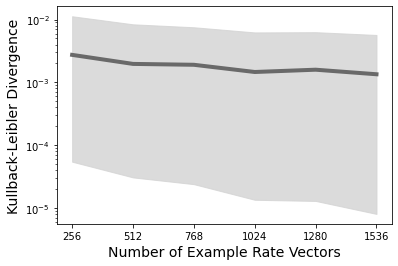

In [306]:
param_95th = [ np.percentile(p[1],95) for p in klds_param ] 
param_5th = [ np.percentile(p[1],5) for p in klds_param ] 
param_means =  [ np.mean(p[1]) for p in klds_param ] 


params = 256*(np.arange(6)+1)

fig, ax = plt.subplots()
ax.plot(params[:], param_means[:], '-',label='Average KLD',color='dimgray',linewidth=lw)
ax.fill_between(params[:], param_95th[:], param_5th[:], alpha=0.8, label = '5th to 95th percentile',color='lightgray')
# plt.title('KLD vs. Number of Examples')
plt.ylabel('Kullback-Leibler Divergence',fontsize=fs)
plt.xlabel('Number of Example Rate Vectors',fontsize=fs)
plt.xticks(params[:], params[:])
#plt.ylim(-0.001,0.02)
plt.yscale('log')
# plt.legend(fontsize=fs)

plt.savefig('./figs/kld_numex.png',dpi=450)


In [307]:
# # plotting them all together

# fig, ax = plt.subplots()
# ax.plot(hid_units[:], hid_means[:], '-',label='Average KLD')
# ax.fill_between(hid_units[:], hid_95th[:], hid_5th[:], alpha=0.2, label = '5th to 95th percentile')
# plt.title('KLD vs. Number of Units in Hidden Layers')
# plt.ylabel('Kullback-Leubler Divergence')
# plt.xlabel('Number of Units in Hidden Layers')
# plt.xticks(hid_units[:], hid_units[:])
# plt.yscale('log')
# plt.legend()
# plt.show()


# fig, ax = plt.subplots()
# ax.plot(npdf[:], npdf_means[:], '-',label='Average KLD',c='green')
# ax.fill_between(npdf[:], npdf_95th[:], npdf_5th[:], alpha=0.2, label = '5th to 95th percentile',color='green')
# plt.title('KLD vs. Number of Basis Functions')
# plt.ylabel('Kullback-Leubler Divergence')
# plt.xlabel('Number of Kernel Functions')
# plt.xticks(npdf[:], npdf[:])
# plt.yscale('log')
# plt.legend()
# plt.show()


# fig, ax = plt.subplots()
# ax.plot(params[:], param_means[:], '-',label='Average KLD',c='red')
# ax.fill_between(params[:], param_95th[:], param_5th[:], alpha=0.2, label = '5th to 95th percentile',color='red')
# plt.title('KLD vs. Number of Examples')
# plt.ylabel('Kullback-Leubler Divergence')
# plt.xlabel('Number of Example Rate Vectors')
# plt.xticks(params[:], params[:])
# #plt.ylim(-0.001,0.02)
# plt.yscale('log')
# plt.legend()
# plt.show();

# Supplementary


Model parameters:

In [308]:
summary(ypm.model)

TypeError: ignored

In [309]:
!zip figs.zip ./figs/*

updating: figs/approx_pmf.png (deflated 36%)
updating: figs/cond0.png (deflated 18%)
updating: figs/cond1.png (deflated 15%)
updating: figs/cond2.png (deflated 15%)
updating: figs/condbig3.png (deflated 17%)
updating: figs/kernels.png (deflated 9%)
  adding: figs/helldist_box.png (deflated 24%)
  adding: figs/hellinger_kde.png (deflated 9%)
  adding: figs/kld_epoch.png (deflated 17%)
  adding: figs/kld_nkernels.png (deflated 19%)
  adding: figs/kld_numex.png (deflated 18%)
  adding: figs/kld_nunits.png (deflated 16%)
  adding: figs/pmf0.png (deflated 42%)
  adding: figs/pmf1.png (deflated 40%)
  adding: figs/pmf2.png (deflated 21%)
  adding: figs/pmf3.png (deflated 60%)
  adding: figs/time_box.png (deflated 25%)
  adding: figs/time_hellinger_scatter.png (deflated 6%)
  adding: figs/time_kde.png (deflated 11%)
  adding: figs/time_numex.png (deflated 13%)
